# **Import**

In [1]:
import torch
import matplotlib.pyplot as plt

# **Setup**

In [6]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')

import os
#GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/EECS442/project'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS442/src/project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
#print(os.listdir(GOOGLE_DRIVE_PATH))

print(torch.cuda.is_available())
# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


# **Data loader**

In [7]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)
from util import load_COCO

if os.path.isfile('./datasets/coco.pt'):
  print('COCO data exist')
else:
  print('downloading COCO dataset')
  !wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt -P ./datasets/

# load COCO data from coco.pt, loaf_COCO is implemented in a4_helper.py
data_dict = load_COCO(path = './datasets/coco.pt')

num_train = data_dict['train_images'].size(0)
num_val = data_dict['val_images'].size(0)

# declare variables for special tokens
NULL_index = data_dict['vocab']['token_to_idx']['<NULL>']
START_index = data_dict['vocab']['token_to_idx']['<START>']
END_index = data_dict['vocab']['token_to_idx']['<END>']
UNK_index = data_dict['vocab']['token_to_idx']['<UNK>']

downloading COCO dataset
--2020-12-12 01:10:03--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396583632 (378M)
Saving to: ‘./datasets/coco.pt’

coco.pt             100%[===================>] 378.21M  54.3MB/s    in 7.8s    

2020-12-12 01:10:11 (48.8 MB/s) - ‘./datasets/coco.pt’ saved [396583632/396583632]

train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])


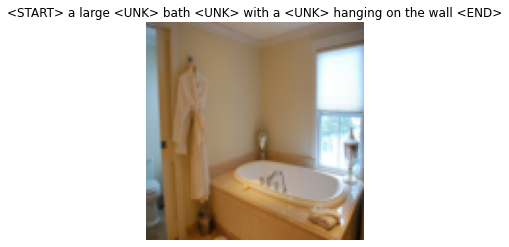

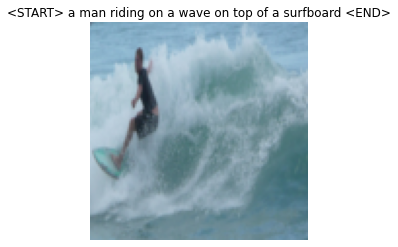

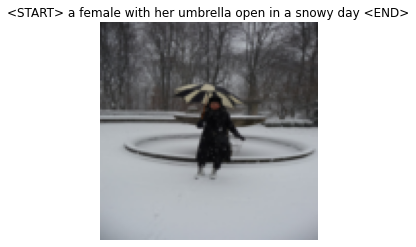

In [8]:
# visualize dataset
from util import decode_captions
batch_size = 3

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  plt.title(caption_str)
  plt.show()

# **Attention**

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



learning rate is:  0.001
(Epoch 0 / 80) loss: 75.1127 time per epoch: 0.2s
(Epoch 1 / 80) loss: 68.8353 time per epoch: 0.1s
(Epoch 2 / 80) loss: 61.5767 time per epoch: 0.1s
(Epoch 3 / 80) loss: 55.1931 time per epoch: 0.1s
(Epoch 4 / 80) loss: 50.9557 time per epoch: 0.1s
(Epoch 5 / 80) loss: 48.2877 time per epoch: 0.1s
(Epoch 6 / 80) loss: 46.2842 time per epoch: 0.0s
(Epoch 7 / 80) loss: 44.6927 time per epoch: 0.0s
(Epoch 8 / 80) loss: 43.4376 time per epoch: 0.0s
(Epoch 9 / 80) loss: 42.4656 time per epoch: 0.0s
(Epoch 10 / 80) loss: 41.4310 time per epoch: 0.0s
(Epoch 11 / 80) loss: 40.7432 time per epoch: 0.0s
(Epoch 12 / 80) loss: 39.8532 time per epoch: 0.1s
(Epoch 13 / 80) loss: 38.9202 time per epoch: 0.0s
(Epoch 14 / 80) loss: 38.3139 time per epoch: 0.0s
(Epoch 15 / 80) loss: 37.3849 time per epoch: 0.0s
(Epoch 16 / 80) loss: 36.5657 time per epoch: 0.0s
(Epoch 17 / 80) loss: 35.7696 time per epoch: 0.0s
(Epoch 18 / 80) loss: 35.0190 time per epoch: 0.0s
(Epoch 19 / 80)

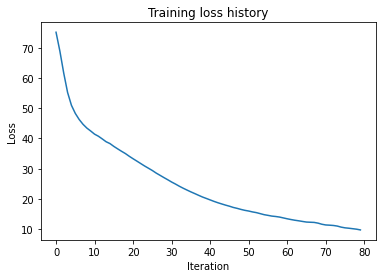

In [9]:
from image_captioner import *
from util import captioning_train

# overfitting test
# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 80
batch_size = 50

# create the image captioning model
model = ImageCaptioner(
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  attn_overfit, _ = captioning_train(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

learning rate is:  0.001
(Epoch 0 / 60) loss: 50.4418 time per epoch: 15.1s
(Epoch 1 / 60) loss: 48.7436 time per epoch: 14.8s
(Epoch 2 / 60) loss: 46.4557 time per epoch: 14.9s
(Epoch 3 / 60) loss: 43.3961 time per epoch: 14.7s
(Epoch 4 / 60) loss: 40.6998 time per epoch: 14.7s
(Epoch 5 / 60) loss: 38.4123 time per epoch: 14.7s
(Epoch 6 / 60) loss: 36.1902 time per epoch: 14.6s
(Epoch 7 / 60) loss: 34.5757 time per epoch: 14.8s
(Epoch 8 / 60) loss: 32.9205 time per epoch: 14.7s
(Epoch 9 / 60) loss: 31.6915 time per epoch: 14.7s
(Epoch 10 / 60) loss: 30.5301 time per epoch: 14.8s
(Epoch 11 / 60) loss: 29.1546 time per epoch: 14.8s
(Epoch 12 / 60) loss: 27.8510 time per epoch: 14.8s
(Epoch 13 / 60) loss: 26.4336 time per epoch: 14.8s
(Epoch 14 / 60) loss: 25.1287 time per epoch: 14.7s
(Epoch 15 / 60) loss: 23.9863 time per epoch: 14.8s
(Epoch 16 / 60) loss: 22.4728 time per epoch: 15.0s
(Epoch 17 / 60) loss: 21.3748 time per epoch: 14.7s
(Epoch 18 / 60) loss: 20.0689 time per epoch: 14.

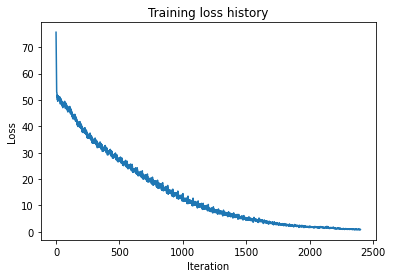

In [ ]:
# training
# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx].to('cuda')
small_caption_data = data_dict['train_captions'][sample_idx].to('cuda')

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
attn_model = ImageCaptioner(
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  attn_model_submit, attn_loss_submit = captioning_train(attn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

In [ ]:
# test
batch_size = 3
from torchvision.utils import make_grid
from torchvision import transforms
from util import attention_visualizer
from nltk.translate.bleu_score import sentence_bleu

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  attn_model.eval()
  generated_captions, attn_weights_all = attn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nAttention LSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()
    
    tokens = generated_captions[i].split(' ')
    
    vis_attn = []
    for j in range(len(tokens)):
      img = sample_images[i]
      attn_weights = attn_weights_all[i][j]
      token = tokens[j]
      img_copy = attention_visualizer(img, attn_weights, token)
      vis_attn.append(transforms.ToTensor()(img_copy))
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vis_attn = make_grid(vis_attn, nrow=8)
    plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)
    print("bleu score is", sentence_bleu([gt_captions[i]], generated_captions[i]))

Output hidden; open in https://colab.research.google.com to view.